In [1]:
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline


/Users/celinaplaza/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Exploratory Data Analysis and Building a model for relationship between greenhouse gas emissions from a car and that car's features

We've collected the data, cleaned it up -- now let's build a model!

### Step 1: Prepare dataframe for developing linear regression model
*Edit and add features as needed for desired model*

-

Open the `all_cars_eda` pickled dataframe with all cars data

In [2]:
with open('pickles/all_cars_eda.pickle','rb') as read_file:
    all_cars_eda = pickle.load(read_file)

-

Create binned categories for `years` to then create dummy columns for. >>

In [3]:
all_cars_eda['year_range'] = ['1984-1999' if year in [1984, 1985, 1986, 
                                                      1987, 1988, 1989, 
                                                      1990, 1991, 1992, 
                                                      1993, 1994, 1995, 
                                                      1996, 1997, 1998, 
                                                      1999] 
                              else '2000-2010' if year in [2000,2001,
                                                           2002,2003,
                                                           2004,2005,
                                                           2006,2007,
                                                           2008,2009,
                                                           2010]
                              else '2011-2021' if year in [2011,2012,
                                                           2013,2014,
                                                           2015,2016,
                                                           2017,2018,
                                                           2019,2020,
                                                           2021]
                              else np.nan for year in all_cars_eda['year']]

-

**REMOVING FEATURES**

**Removing miles-per-gallon - `mpg`.**  By removing we'll allow opportunity to examine any relationships between the other features of the car and the greenhouse gas emissions, otherwise miles-per-gallon would be too dominant of feature and also isn't really telling us more deeply what causes greenhouse gas emissions from the mechanics of how the car was built

**Removing `make`, `model`, & `trans_speed`.**  Can say with confidence these are not signiciantly relevant to the greenhouse gas emissions of the car and would not be worth create dummies for the non-numberic categories.

**Removing `year`.**  Will just use the dummy columns created for years.

In [149]:
del all_cars_eda['mpg']
del all_cars_eda['make']
del all_cars_eda['model']
del all_cars_eda['trans_speed']
del all_cars_eda['year']

Verify everything looks okay >>

In [150]:
all_cars_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5265 entries, 0 to 5264
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   capacity_liters  5265 non-null   float64
 1   cylinders        5265 non-null   int32  
 2   transmission     5265 non-null   object 
 3   fuel_type        5265 non-null   object 
 4   gg_emissions     5265 non-null   float64
 5   year_range       5265 non-null   object 
dtypes: float64(2), int32(1), object(3)
memory usage: 226.4+ KB


-

Create the dummies for the features that are objects >>

In [151]:
all_cars_eda = pd.get_dummies(all_cars_eda)

In [152]:
all_cars_eda.rename(columns = {'fuel_type_Midgrade Gasoline': 'fuel_midgrade',
                               'fuel_type_Natural Gas': 'fuel_natural_gas',
                               'fuel_type_Premium Gasoline': 'fuel_premium',
                               'fuel_type_Regular Gasoline': 'fuel_regular',
                               'year_range_1984-1999': 'years_1984_1999',
                               'year_range_2000-2010': 'years_2000_2010',
                               'year_range_2011-2021': 'years_2011_2021'
                              },
                    inplace = True)

### Step 2: Exploratory Data Analysis

Examine the correlations of all the values>>

In [153]:
all_cars_eda.corr()

,capacity_liters,cylinders,gg_emissions,transmission_Automatic,transmission_Manual,fuel_type_Diesel,fuel_midgrade,fuel_natural_gas,fuel_premium,fuel_regular,years_1984_1999,years_2000_2010,years_2011_2021
capacity_liters,1.000000,0.906518,0.774102,0.265351,-0.265351,0.125489,0.005628,0.044656,0.134410,-0.200353,-0.004085,0.167697,-0.135983
cylinders,0.906518,1.000000,0.740740,0.310327,-0.310327,0.064461,0.005245,0.044364,0.252358,-0.277398,-0.063083,0.189541,-0.092253
gg_emissions,0.774102,0.740740,1.000000,0.169951,-0.169951,-0.010660,-0.001571,0.029038,0.117307,-0.106430,0.187043,0.171359,-0.339908
transmission_Automatic,0.265351,0.310327,0.169951,1.000000,-1.000000,-0.059138,0.009875,0.019756,0.195863,-0.153149,-0.378733,0.033095,0.370337
transmission_Manual,-0.265351,-0.310327,-0.169951,-1.000000,1.000000,0.059138,-0.009875,-0.019756,-0.195863,0.153149,0.378733,-0.033095,-0.370337
fuel_type_Diesel,0.125489,0.064461,-0.010660,-0.059138,0.059138,1.000000,-0.004121,-0.008244,-0.198073,-0.375459,0.126832,-0.098701,-0.050730
fuel_midgrade,0.005628,0.005245,-0.001571,0.009875,-0.009875,-0.004121,1.000000,-0.000380,-0.009131,-0.017309,-0.012775,-0.006801,0.019115
fuel_natural_gas,0.044656,0.044364,0.029038,0.019756,-0.019756,-0.008244,-0.000380,1.000000,-0.018268,-0.034628,-0.025558,0.055878,-0.019882
fuel_premium,0.134410,0.252358,0.117307,0.195863,-0.195863,-0.198073,-0.009131,-0.018268,1.000000,-0.831994,-0.350120,0.128394,0.260550
fuel_regular,-0.200353,-0.277398,-0.106430,-0.153149,0.153149,-0.375459,-0.017309,-0.034628,-0.831994,1.000000,0.261182,-0.068691,-0.217024


-

Now narrow in on just the greenhouse gas emissions column (the 'y') to examine the value of greatest interest more easily >>

In [154]:
(all_cars_eda.corr()).iloc[:,2]

capacity_liters           0.774102
cylinders                 0.740740
gg_emissions              1.000000
transmission_Automatic    0.169951
transmission_Manual      -0.169951
fuel_type_Diesel         -0.010660
fuel_midgrade            -0.001571
fuel_natural_gas          0.029038
fuel_premium              0.117307
fuel_regular             -0.106430
years_1984_1999           0.187043
years_2000_2010           0.171359
years_2011_2021          -0.339908
Name: gg_emissions, dtype: float64

-

Now create a heatmap to help look at the relationships of the values >>

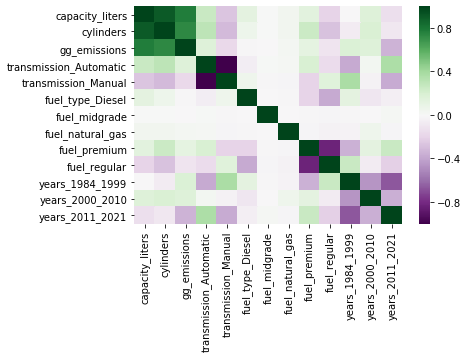

In [155]:
ax = sns.heatmap(all_cars_eda.corr(), cmap="PRGn")
ax.set_ylim(13.0, 0);

Create a pair plot for a deeper look at relationship between all features and variable >>

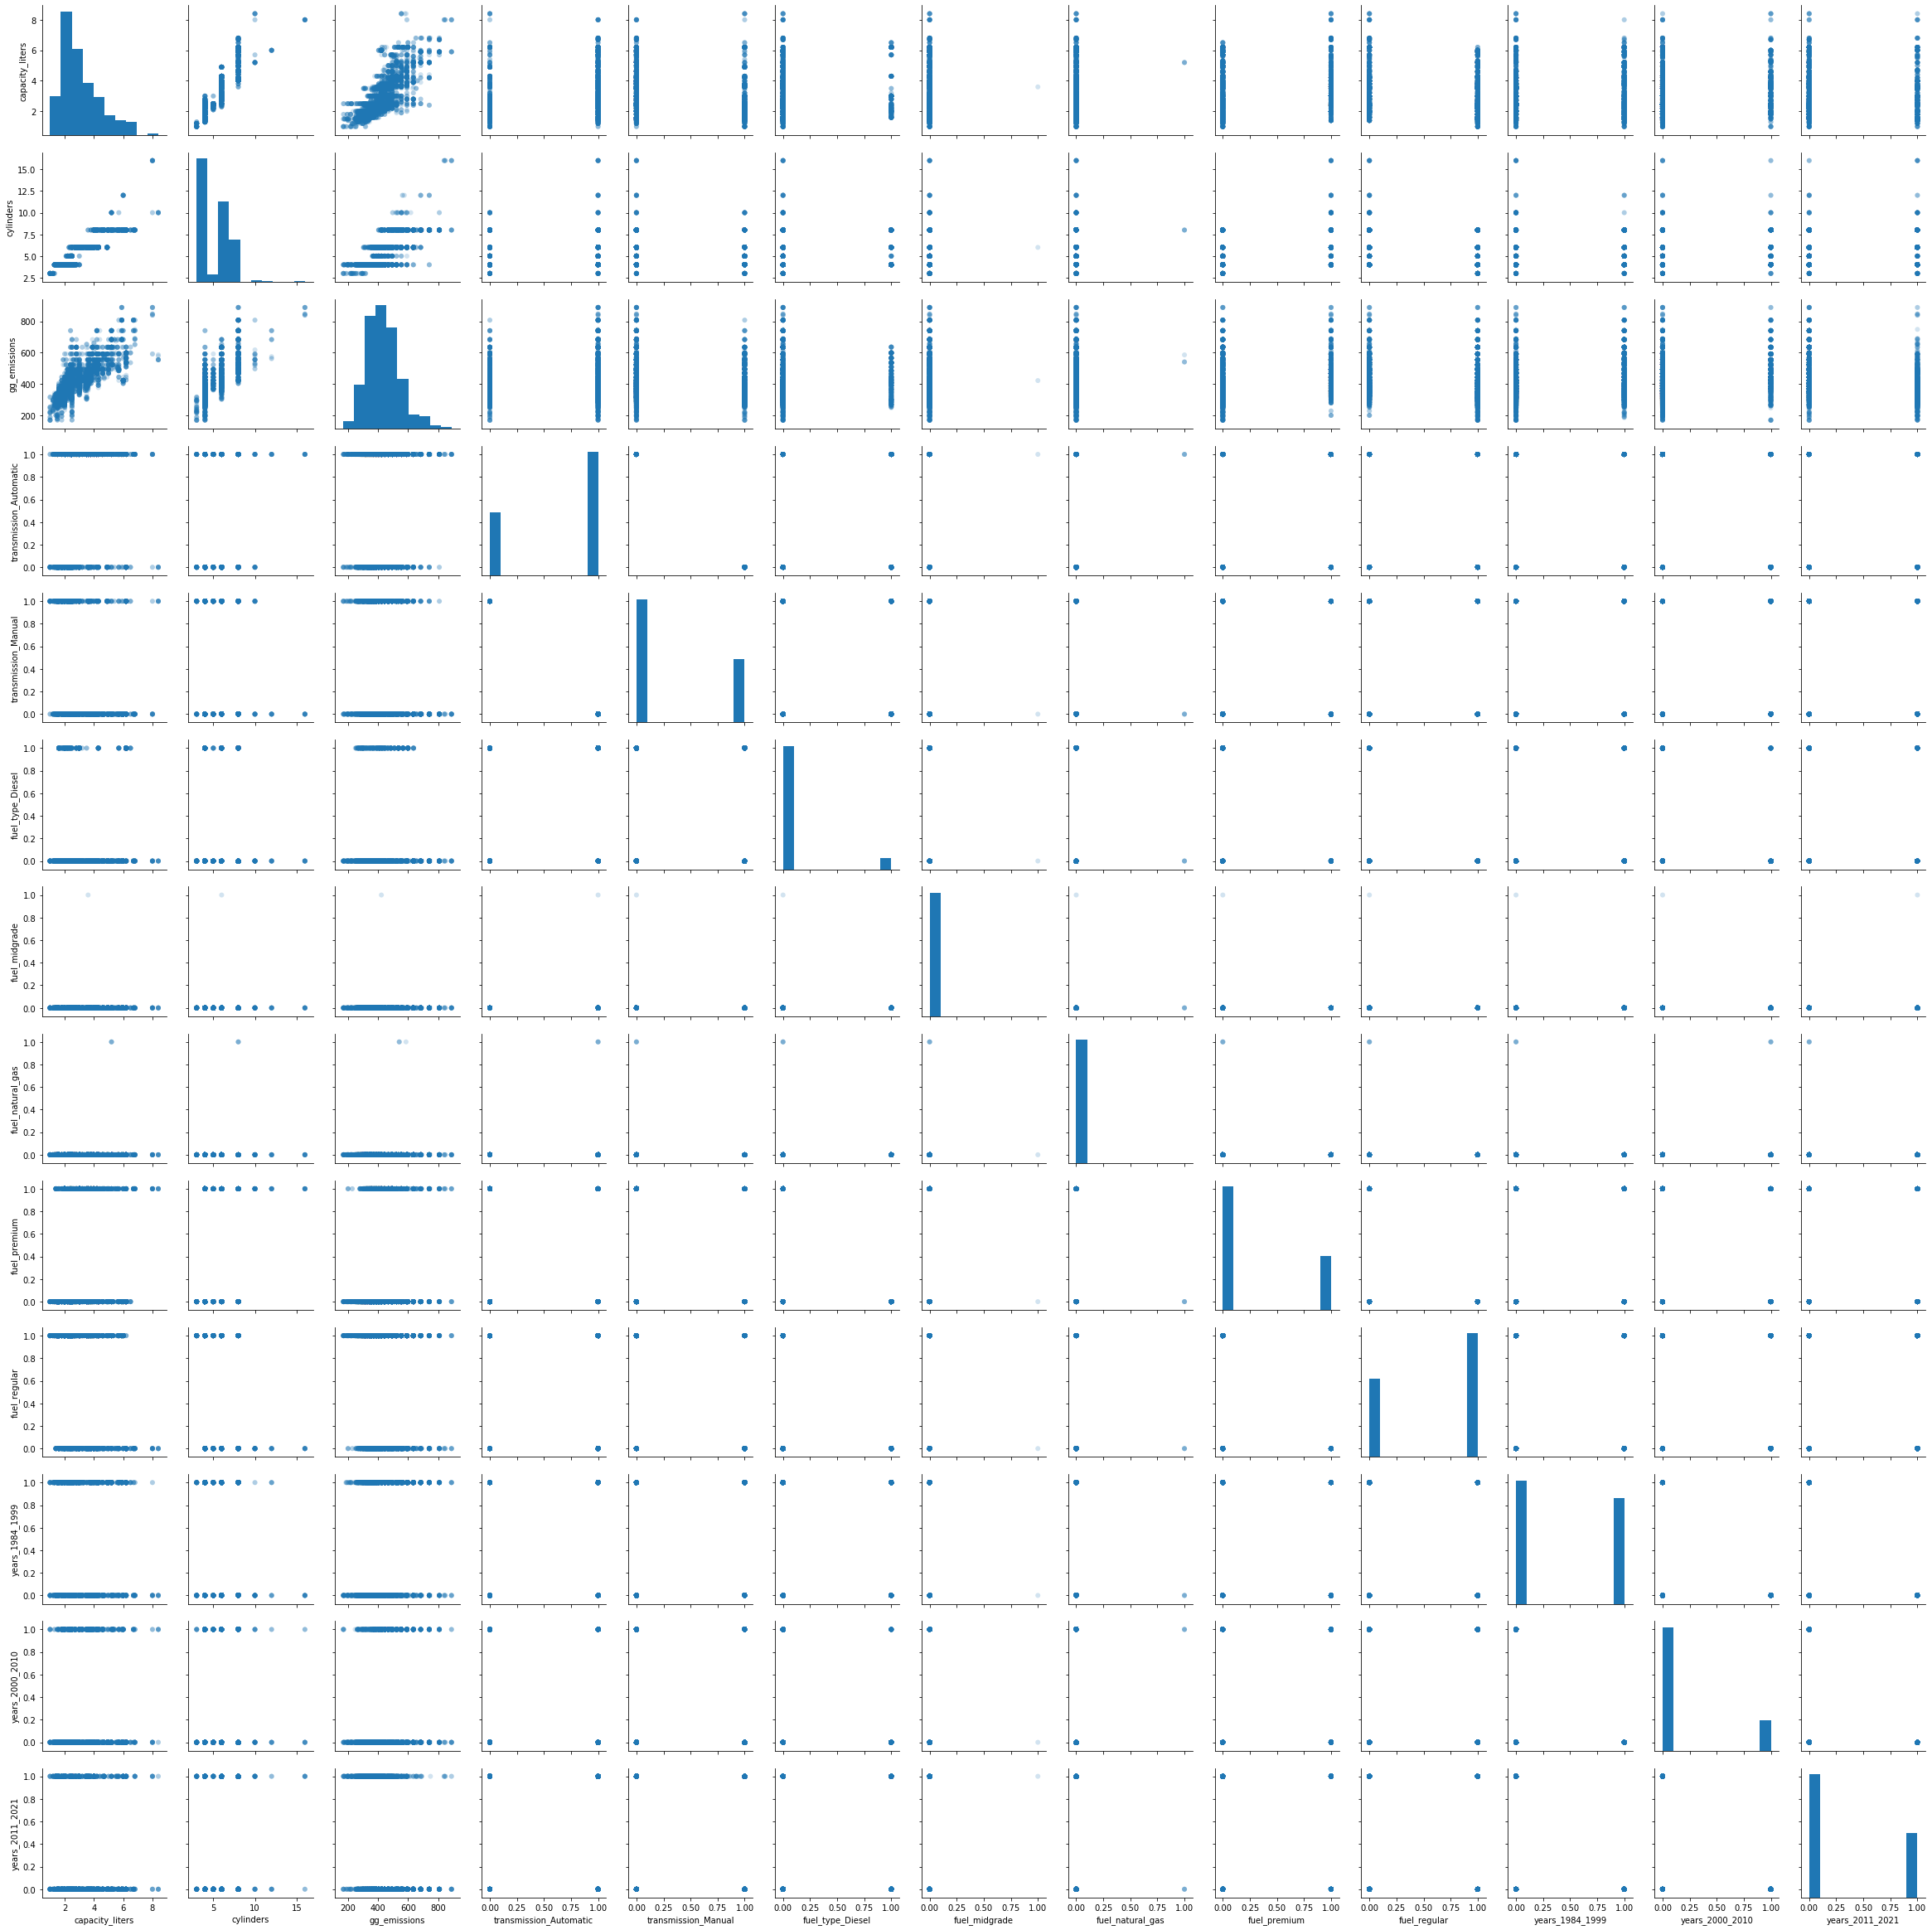

In [156]:
sns.pairplot(all_cars_eda, plot_kws=dict(alpha=.2, edgecolor='none'));

In [158]:
# Define the model for greenhouse gas emissions of cars
cars_model = smf.ols('''gg_emissions ~ capacity_liters + cylinders 
              + transmission_Automatic + transmission_Manual
              + fuel_type_Diesel + fuel_midgrade + fuel_natural_gas
              + fuel_premium + fuel_regular + years_1984_1999
              + years_2000_2010 + years_2011_2021''',data=all_cars_eda)

# Fit the model
cars_fit = cars_model.fit()

# Print summary statistics of the model's performance
cars_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gg_emissions   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1293.
Date:                Sat, 11 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:21:03   Log-Likelihood:                -29222.
No. Observations:                5265   AIC:                         5.846e+04
Df Residuals:                    5255   BIC:                         5.853e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 98.1309      7.114     13.795      0.000      84.185     112.077
capacity_liters           46.6975      1.597     29.245      0.000      43.567      49.828
cylinders                 13.6723      1.331     10.269      0.000      11.062      16.282
transmission_Automatic    57.0693      3.762     15.171      0.000      49.695      64.444
transmission_Manual       41.0616      3.663     11.209      0.000      33.880      48.243
fuel_type_Diesel          -9.9902     12.832     -0.779      0.436     -35.146      15.166
fuel_midgrade             26.0688     51.404      0.507      0.612     -74.704     126.841
fuel_natural_gas           4.2746     27.972      0.153      0.879     -50.562      59.111
fuel_premium              45.5985     12.660      3.602      0.000      20.780      70.417
fuel_regular              32.1792     12.625      2.549      0.011       7.428      56.930
years_1984_1999           66.9743      2.730     24.531      0.000      61.622      72.327
years_2000_2010           40.5702      2.860     14.186      0.000      34.964      46.177
years_2011_2021           -9.4136      2.678     -3.515      0.000     -14.664      -4.163
==============================================================================
Omnibus:                      364.276   Durbin-Watson:                   0.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              782.000
Skew:                           0.455   Prob(JB):                    1.55e-170
Kurtosis:                       4.654   Cond. No.                     7.35e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.35e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

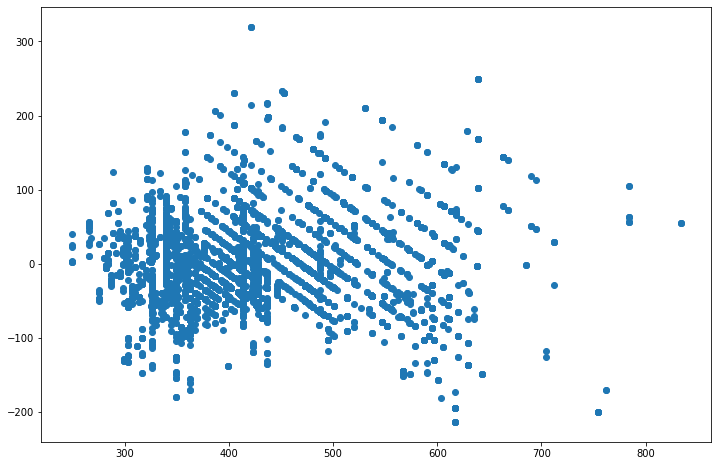

In [159]:
# Plot the residuals vs the fitted values

plt.figure(figsize=(12,8))
plt.scatter(cars_fit.predict(), cars_fit.resid);

In [161]:
all_cars_eda.columns

Index(['capacity_liters', 'cylinders', 'gg_emissions',
       'transmission_Automatic', 'transmission_Manual', 'fuel_type_Diesel',
       'fuel_midgrade', 'fuel_natural_gas', 'fuel_premium', 'fuel_regular',
       'years_1984_1999', 'years_2000_2010', 'years_2011_2021'],
      dtype='object')

In [162]:
# Using Sklearn to get R**2 value -- should be same as above

# Create an empty model
cars_lr = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X2 + X3 + X4 + X5 + X6 model
X = all_cars_eda.loc[:, ['capacity_liters', 'cylinders', 'transmission_Automatic', 
                         'transmission_Manual', 'fuel_type_Diesel', 'fuel_midgrade',
                         'fuel_natural_gas','fuel_premium','fuel_regular',
                         'years_1984_1999','years_2000_2010','years_2011_2021'
                        ]]

# Choose the response variable(s)
y = all_cars_eda.loc[:, ['gg_emissions']]

# Fit the model to the full dataset
cars_lr.fit(X, y)

# Print out the R^2 for the model against the full dataset
cars_lr.score(X,y)

0.6888497216196408

In [163]:
# use sklearn to find other intercept
cars_lr.intercept_

array([199.53279762])

In [164]:
# use sklearn to find other coefficients
cars_lr.coef_

array([[ 46.69746523,  13.67227487,   8.00388736,  -8.00388736,
        -29.61638487,   6.44266834, -15.35158889,  25.97232108,
         12.55298434,  34.26399156,   7.85988579, -42.12387734]])